In [1]:
from vaderSentiment.vaderSentiment import SentimentIntensityAnalyzer
import pandas as pd
import pyspark.sql.functions as F
from pyspark.sql.functions import col, udf, to_date
from pyspark.sql.types import FloatType
import matplotlib.pyplot as plt
import pyspark
from pyspark import SparkContext
from pyspark.sql import SparkSession, SQLContext

In [2]:
print(pyspark.__version__)
 


3.2.4


In [3]:
df = (spark.read
      .format("mongo")
      .option("spark.mongodb.input.uri", "mongodb://localhost:27017")
      .option("spark.mongodb.input.database", "TrumpTweets")
      .option("spark.mongodb.input.collection", "TrumpTweetsCollection")
      .option("spark.mongodb.input.partitioner", "MongoSinglePartitioner")
      .load())


df = (spark.read
      .format("mongo")
      .option("spark.mongodb.input.uri", "mongodb://localhost:27017")
      .option("spark.mongodb.input.database", "TrumpDB")
      .option("spark.mongodb.input.collection", "TrumpCollection")
      .option("spark.mongodb.input.partitioner", "MongoSinglePartitioner")
      .load())


In [4]:
print(df.columns)

['_id', 'content', 'date', 'favorites', 'hashtags', 'id', 'link', 'mentions', 'retweets']


In [5]:
df = df.select("date", "content")

In [6]:
print(df.count())

43352


In [ ]:
#df.show()

In [7]:
tweets = df.na.drop()


In [8]:
tweets.count()

43352

In [9]:
tweets.show()

+-------------------+--------------------+
|               date|             content|
+-------------------+--------------------+
|2009-05-04 13:54:25|Be sure to tune i...|
|2009-05-04 20:00:10|Donald Trump will...|
|2009-05-08 08:38:08|Donald Trump read...|
|2009-05-08 15:40:15|New Blog Post: Ce...|
|2009-05-12 09:07:28|"My persona will ...|
|2009-05-12 14:21:55|Miss USA Tara Con...|
|2009-05-13 12:38:28|Listen to an inte...|
|2009-05-14 11:30:40|"Strive for whole...|
|2009-05-15 09:13:13|Enter the "Think ...|
|2009-05-16 17:22:45|"When the achieve...|
|2009-05-17 10:00:03|"Don’t be afraid ...|
|2009-05-18 09:26:00|"We win in our li...|
|2009-05-19 12:43:39|"...these days......|
|2009-05-20 08:25:39|"Always know you ...|
|2009-05-20 17:29:47|Read a great inte...|
|2009-05-21 21:59:39|"Keep it fast, sh...|
|2009-05-22 11:28:34|Don't forget to e...|
|2009-05-23 11:11:19|Did you know Dona...|
|2009-05-26 09:42:01|"Your higher self...|
|2009-05-27 09:18:52|Read an excerpt f...|
+----------

In [10]:
analyzer = SentimentIntensityAnalyzer()

def analyze_sentiment(text):
    return analyzer.polarity_scores(text)["compound"]

sentiment_udf = udf(analyze_sentiment, FloatType())
spark.udf.register("sentiment_udf", sentiment_udf)

<function __main__.analyze_sentiment(text)>

In [11]:
# Convert timestamp to date
tweets = tweets.withColumn("date", to_date(col("date")))

# Calculate sentiment score for each tweet
tweets = tweets.withColumn("sentiment", sentiment_udf(col("content")))


In [12]:
tweets.show()

+----------+--------------------+---------+
|      date|             content|sentiment|
+----------+--------------------+---------+
|2009-05-04|Be sure to tune i...|   0.5255|
|2009-05-04|Donald Trump will...|   0.7712|
|2009-05-08|Donald Trump read...|   0.6468|
|2009-05-08|New Blog Post: Ce...|      0.0|
|2009-05-12|"My persona will ...|      0.0|
|2009-05-12|Miss USA Tara Con...|   0.4809|
|2009-05-13|Listen to an inte...|   0.7506|
|2009-05-14|"Strive for whole...|   0.2023|
|2009-05-15|Enter the "Think ...|   0.7506|
|2009-05-16|"When the achieve...|      0.0|
|2009-05-17|"Don’t be afraid ...|   0.7717|
|2009-05-18|"We win in our li...|   0.5859|
|2009-05-19|"...these days......|      0.0|
|2009-05-20|"Always know you ...|   0.6249|
|2009-05-20|Read a great inte...|   0.6249|
|2009-05-21|"Keep it fast, sh...|      0.0|
|2009-05-22|Don't forget to e...|   0.7944|
|2009-05-23|Did you know Dona...|   0.3802|
|2009-05-26|"Your higher self...|   0.3612|
|2009-05-27|Read an excerpt f...

In [13]:
groupedDF = tweets.groupBy("date") \
    .agg(F.mean("sentiment").alias("avg_sentiment")) \
    .orderBy("date")

In [14]:
groupedDF.show()

+----------+-------------------+
|      date|      avg_sentiment|
+----------+-------------------+
|2009-05-04| 0.6483500003814697|
|2009-05-08|0.32339999079704285|
|2009-05-12|0.24044999480247498|
|2009-05-13| 0.7505999803543091|
|2009-05-14|0.20229999721050262|
|2009-05-15| 0.7505999803543091|
|2009-05-16|                0.0|
|2009-05-17| 0.7717000246047974|
|2009-05-18| 0.5859000086784363|
|2009-05-19|                0.0|
|2009-05-20| 0.6248999834060669|
|2009-05-21|                0.0|
|2009-05-22| 0.7943999767303467|
|2009-05-23|0.38019999861717224|
|2009-05-26| 0.3612000048160553|
|2009-05-27| 0.7505999803543091|
|2009-05-28|                0.0|
|2009-06-03|                0.0|
|2009-06-05| 0.3935000002384186|
|2009-06-08| 0.7505999803543091|
+----------+-------------------+
only showing top 20 rows



In [15]:
groupedPD = groupedDF.toPandas()

In [25]:
groupedPD['moving_average'] = groupedPD['avg_sentiment'].rolling(window=365).mean()

/tmp/ipykernel_2893/2736247694.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  groupedPD['moving_average'] = groupedPD['avg_sentiment'].rolling(window=365).mean()


In [26]:
groupedPD['date'] = pd.to_datetime(groupedPD['date'] )

/tmp/ipykernel_2893/1753231781.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  groupedPD['date'] = pd.to_datetime(groupedPD['date'] )


In [27]:
groupedPD = groupedPD[groupedPD['date'].dt.year > 2013]

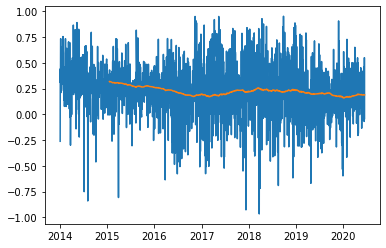

In [28]:
plt.plot(groupedPD['date'],groupedPD['avg_sentiment'])
plt.plot(groupedPD['date'],groupedPD['moving_average'])